# Dataset

In [124]:
import pandas as pd
import numpy as np

import os
from datetime import datetime, timedelta
import re

from module import toSunpyMap

from astropy.coordinates import SkyCoord
import astropy.units as u
from sunpy.coordinates import HeliographicStonyhurst, RotatedSunFrame

import matplotlib.pyplot as plt


In [125]:
def convert_to_lon_lat(location):
    # Latitude
    lat_sign = 1 if location[0] == 'N' else -1
    latitude = lat_sign * int(location[1:3])
    
    # Longitude
    lon_sign = -1 if location[3] == 'E' else 1
    longitude = lon_sign * int(location[4:])
    
    return longitude, latitude


# Extract datetime from filename using regex
def extract_datetime_from_filename(filename):
    match = re.search(r'_(\d{8}_\d{6}\d{2})_', filename)  # Adjusted regex to match milliseconds
    if match:
        datetime_str = match.group(1)
        try:
            return datetime.strptime(datetime_str, '%Y%m%d_%H%M%S%f')
        except ValueError as e:
            print(f"Error parsing datetime string: {datetime_str}, error: {e}")
    return None


# Function to find the closest file to a given time
def find_closest_file(target_time, files):
    closest_file_dt = None
    min_diff = timedelta.max
    for file, file_time in files:
        diff = abs(file_time - target_time)
        if diff < min_diff:
            min_diff = diff
            closest_file_dt = (file, file_time)
            
    if min_diff>timedelta(minutes=5): 
        return None
    
    return closest_file_dt

In [126]:
def getTimeSeriesForEvent(event):
        
    # Event start date and time
    event_datetime = datetime.strptime(event['start'], '%Y/%m/%d %H:%M')

    directory = 'Y:/data/CLIMSO/'+str(event_datetime.year)+'/data_calibrated/'+event_datetime.strftime('%Y-%m-%d')+'/'

    if not os.path.exists(directory):
        return None

    ## L1
    
    # List all files in the directory for l1
    l1_files = [file for file in os.listdir(directory) if file.startswith('imoa_06563_l1_')]
    # Create a list of (filename, datetime) tuples
    l1_file_datetimes = [(file, extract_datetime_from_filename(file)) for file in l1_files]
    # Filter out any files that did not match the pattern or had parsing issues
    l1_file_datetimes = [fd for fd in l1_file_datetimes if fd[1] is not None]
    # Sort files by datetime
    l1_file_datetimes.sort(key=lambda x: x[1])
    
    ## L2
    
    # List all files in the directory for l1
    l2_files = [file for file in os.listdir(directory) if file.startswith('imoa_03933_l2_')]
    # Create a list of (filename, datetime) tuples
    l2_file_datetimes = [(file, extract_datetime_from_filename(file)) for file in l2_files]
    # Filter out any files that did not match the pattern or had parsing issues
    l2_file_datetimes = [fd for fd in l2_file_datetimes if fd[1] is not None]
    # Sort files by datetime
    l2_file_datetimes.sort(key=lambda x: x[1])
    

    # Find the files closest to each interval before the event datetime
    l1_closest_files = []
    l2_closest_files = []
    current_time = event_datetime

    for i in range(6):
        current_time -= timedelta(minutes=10)
        l1_closest_file_dt = find_closest_file(current_time, l1_file_datetimes)
        l2_closest_file_dt = find_closest_file(current_time, l2_file_datetimes)
        if l1_closest_file_dt and l2_closest_file_dt:
            l1_closest_files.append(directory+l1_closest_file_dt[0])
            l2_closest_files.append(directory+l2_closest_file_dt[0])
            l1_file_datetimes.remove(l1_closest_file_dt)
            l2_file_datetimes.remove(l2_closest_file_dt)
        elif l1_closest_file_dt is None or l2_closest_file_dt is None:
            return None


    # Output the closest filenames
    return (l1_closest_files, l2_closest_files)

In [127]:
def createSample(event, flip=False):
    
    files = getTimeSeriesForEvent(event)
    if files is None : return
    print('found files')
    
    lon, lat = convert_to_lon_lat(event['AR location'])
    label = event['X-ray class'][0]
    
    directory = 'dataset/' + label + '/' + str(event['Event number'])
    os.makedirs(directory + '/l1/', exist_ok=True)
    os.makedirs(directory + '/l2/', exist_ok=True)
    
    for i in range(6):
        l1_map = toSunpyMap(files[0][i], center_disk=True)
        coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=l1_map.date)
        x, y = [int(pixel_coord.value) for pixel_coord in l1_map.world_to_pixel(coord)]
        y=2048-y

        if flip : 
            data=np.flip(l1_map.data, axis=0) 
        else : 
            data=l1_map.data

        l1_image = data[y-125:y+125, x-125:x+125]

        l2_map = toSunpyMap(files[1][i], center_disk=True)
        coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=l2_map.date)
        x, y = [int(pixel_coord.value) for pixel_coord in l2_map.world_to_pixel(coord)]
        y=2048-y

        if flip : 
            data=np.flip(l2_map.data, axis=0) 
        else : 
            data=l2_map.data
            
        l2_image = data[y-125:y+125, x-125:x+125]
        
        plt.imsave(f'{directory}/l1/img{str(i)}.png', l1_image.astype(np.uint16), cmap='gray', vmin=0, vmax=65535, format='png')
        plt.imsave(f'{directory}/l2/img{str(i)}.png', l2_image.astype(np.uint16), cmap='gray', vmin=0, vmax=32767, format='png')       

### main

In [128]:
df = pd.read_csv('FlareCatalogue.csv')

In [174]:
event = df[df['Event number']==217350].iloc[0]
event

Event number              217350
start           2022/10/05 11:54
peak            2022/10/05 12:03
end             2022/10/05 12:08
AR location               N26E33
X-ray class                 C2.2
FG                             0
SP                           0.0
XRT                            0
EIS                            0
DARTS                        NaN
RHESSI                        no
Suzaku/WAM                   NaN
NoRH                         NaN
Name: 2639, dtype: object

In [175]:
files = getTimeSeriesForEvent(event)
files

(['Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_06563_l1_20221005_11440750_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_06563_l1_20221005_11340033_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_06563_l1_20221005_11235299_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_06563_l1_20221005_11133892_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_06563_l1_20221005_11033167_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_06563_l1_20221005_10542502_emi1.fts.bz2'],
 ['Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_03933_l2_20221005_11443001_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_03933_l2_20221005_11342332_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_03933_l2_20221005_11241945_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_calibrated/2022-10-05/imoa_03933_l2_20221005_11130423_emi1.fts.bz2',
  'Y:/data/CLIMSO/2022/data_c

In [176]:
lon, lat = convert_to_lon_lat(event['AR location'])

event_datetime = datetime.strptime(event['start'], '%Y/%m/%d %H:%M').replace(hour=0, minute=0)

event_coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=event_datetime)


In [177]:
lon, lat = convert_to_lon_lat(event['AR location'])

i=0
flip=True

l1_map = toSunpyMap(files[0][i], center_disk=True)
coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=l1_map.date)
x, y = [int(pixel_coord.value) for pixel_coord in l1_map.world_to_pixel(coord)]
y=2048-y

if flip : 
    data=np.flip(l1_map.data, axis=0) 
else : 
    data=l1_map.data

l1_image = data[y-125:y+125, x-125:x+125]

l2_map = toSunpyMap(files[1][i], center_disk=True)
coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=l2_map.date)
x, y = [int(pixel_coord.value) for pixel_coord in l2_map.world_to_pixel(coord)]
y=2048-y

if flip : 
    data=np.flip(l2_map.data, axis=0) 
else : 
    data=l2_map.data
    
l2_image = data[y-125:y+125, x-125:x+125]

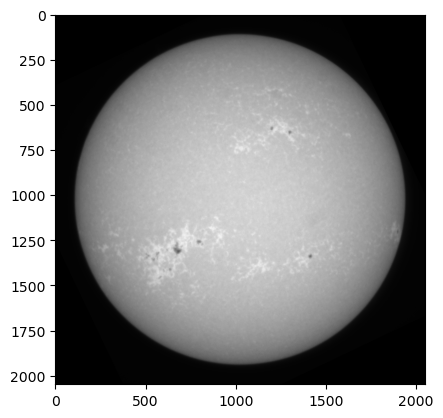

In [178]:
plt.imshow(data, cmap='gray')

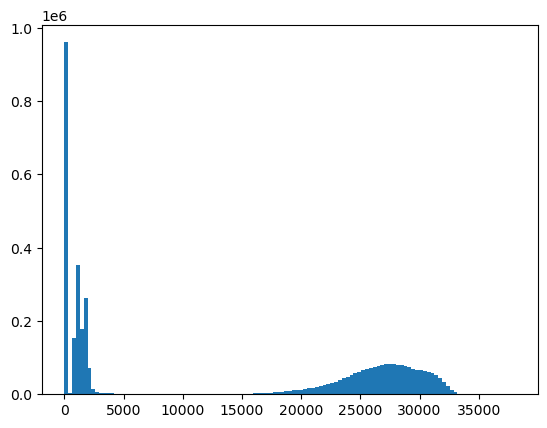

In [133]:
plt.hist(l1_map.data.flatten(),bins='auto');

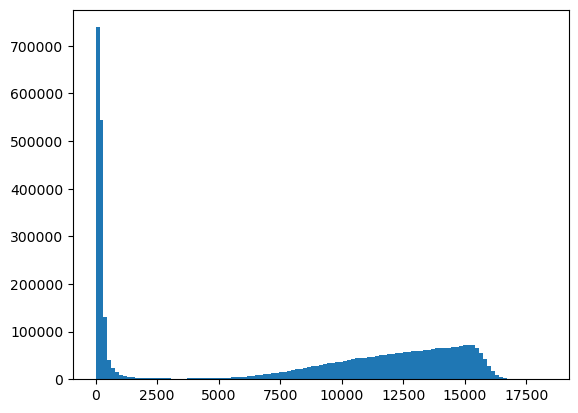

In [134]:
plt.hist(l2_map.data.flatten(),bins='auto');

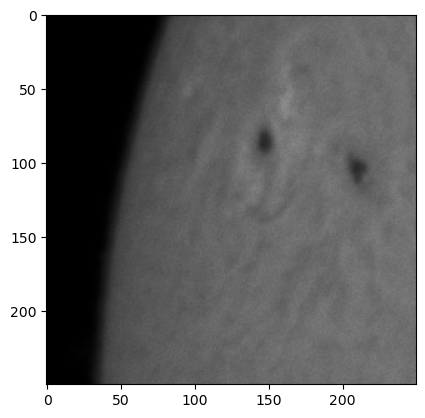

In [173]:
plt.imshow(l1_image, cmap='grey', vmin=0, vmax=65535)


### Loop

In [182]:
for index, event in df.iterrows():
    if index>7615:
        print(index, '|', event['Event number'])
        createSample(event, flip=False)

7616 | 167580
found files


SystemError: tile cannot extend outside image